<a href="https://colab.research.google.com/github/SHRAVAN-AMBEER/Machine-Learning-Lab/blob/main/ML_Assignment_1/ml_assignment_1(168).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Regression**

#Part (a) & (b) – Load dataset + train/test split

In [31]:
# (a) Load dataset and prepare X, y
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset (Breast Cancer from sklearn)
data = load_breast_cancer()
X_raw = data.data
y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# (b) Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (455, 30)
Test shape: (114, 30)


#(c) Logistic Regression Objective with L2 regularization:


 J(w, b) = (1/N) * sum [ -y_i log sigma(z_i) - (1-y_i) log(1 - sigma(z_i)) ] + (lambda/2) ||w||**2

 where z_i = w^T x_i + b and sigma(z) = sigmoid(z).

 We’ll implement it using sklearn's LogisticRegression.

# Part (d) – Logistic regression with L2 across λ

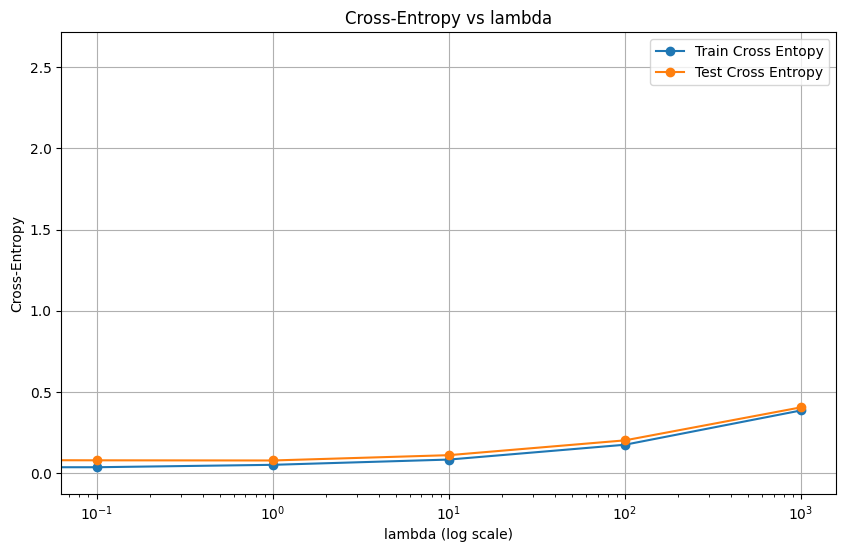

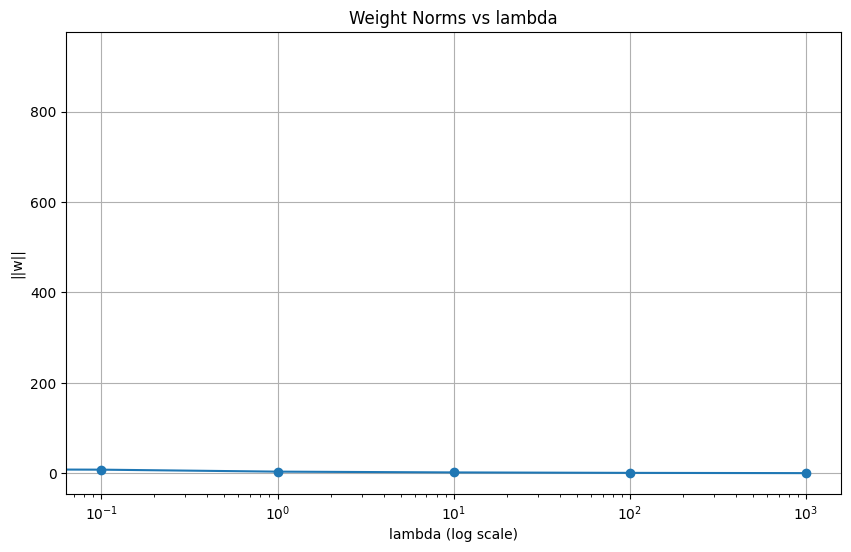

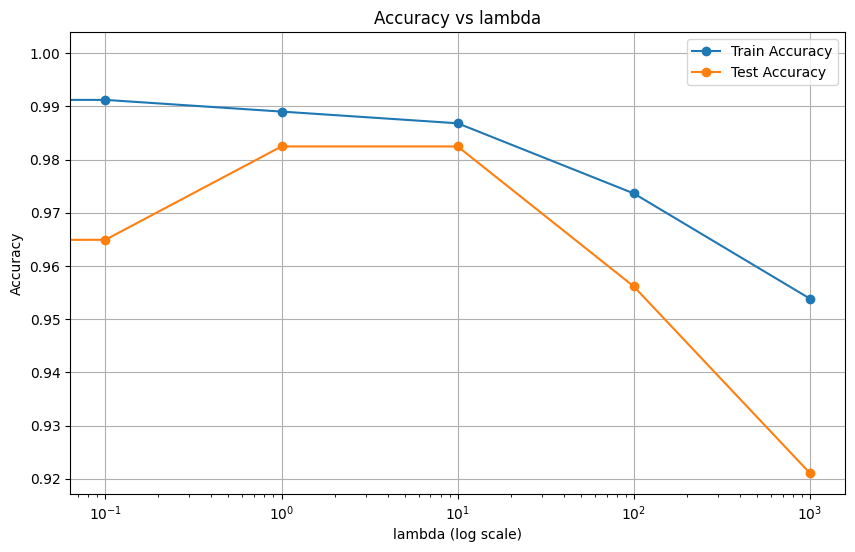

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

def fit_eval_logreg(X_train_data, y_train_data, X_test_data, y_test_data, lambda_val):
    if lambda_val == 0:
        clf = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
    else:
        clf = LogisticRegression(penalty="l2", C=1/lambda_val, solver='liblinear', max_iter=5000)
    clf.fit(X_train_data, y_train_data)

    # Predictions
    prob_train = clf.predict_proba(X_train_data)[:,1]
    prob_test = clf.predict_proba(X_test_data)[:,1]

    # Calculate metrics
    cross_entropy_train = log_loss(y_train_data, prob_train)
    cross_entropy_test = log_loss(y_test_data, prob_test)
    accuracy_train = accuracy_score(y_train_data, prob_train >= 0.5)
    accuracy_test = accuracy_score(y_test_data, prob_test >= 0.5)

    return {
        "lambda_val": lambda_val,
        "weights": clf.coef_.ravel(),
        "cross_entropy_train": cross_entropy_train,
        "cross_entropy_test": cross_entropy_test,
        "accuracy_train": accuracy_train,
        "accuracy_test": accuracy_test
    }

# Sweep over λ values
lambdas = [0, 0.1, 1, 10, 100, 1000]
results = [fit_eval_logreg(X_train, y_train, X_test, y_test, lambda_val=lam) for lam in lambdas]

# Convert results for plotting
cross_entropy_train = [r["cross_entropy_train"] for r in results]
cross_entropy_test = [r["cross_entropy_test"] for r in results]
accuracy_train = [r["accuracy_train"] for r in results]
accuracy_test = [r["accuracy_test"] for r in results]
weights_norms = [np.linalg.norm(r["weights"]) for r in results]

# Plot Cross-Entropy vs λ
plt.figure(figsize=(10, 6))
plt.plot(lambdas, cross_entropy_train, 'o-', label="Train Cross Entopy")
plt.plot(lambdas, cross_entropy_test, 'o-', label="Test Cross Entropy")
plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("Cross-Entropy")
plt.title("Cross-Entropy vs lambda")
plt.legend()
plt.grid(True)
plt.show()

# Plot Weight Norms
plt.figure(figsize=(10, 6))
plt.plot(lambdas, weights_norms, 'o-')
plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("||w||")
plt.title("Weight Norms vs lambda")
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(lambdas, accuracy_train, 'o-', label="Train Accuracy")
plt.plot(lambdas, accuracy_test, 'o-', label="Test Accuracy")
plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs lambda")
plt.legend()
plt.grid(True)
plt.show()

#Part (e) & (f) – Gaussian Basis Functions

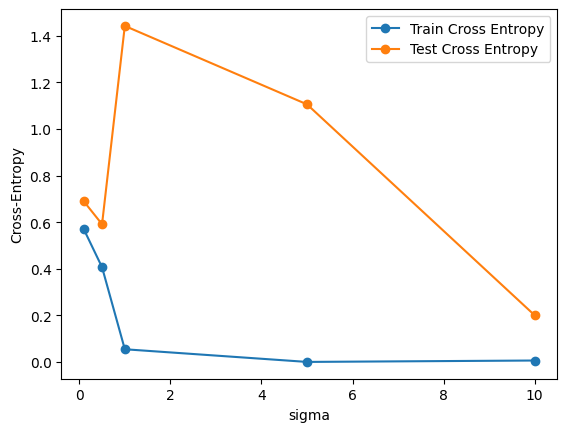

In [41]:
# Build Gaussian basis features
def gaussian_basis(X, sigma, K=5):
    mus = np.linspace(-10, 10, K)
    Phi_list = []
    for j in range(X.shape[1]):
        xj = X[:, j:j+1]
        feats = np.exp(- (xj - mus)**2 / (2*sigma**2))
        Phi_list.append(feats)
    return np.concatenate(Phi_list, axis=1)

sigmas = [0.1, 0.5, 1, 5, 10]
cross_entropy_train_sigma, cross_entropy_test_sigma = [], []

for sigma in sigmas:
    Phi_train = gaussian_basis(X_train, sigma)
    Phi_test = gaussian_basis(X_test, sigma)
    res = fit_eval_logreg(Phi_train, y_train, Phi_test, y_test, lambda_val=0)
    cross_entropy_train_sigma.append(res["cross_entropy_train"])
    cross_entropy_test_sigma.append(res["cross_entropy_test"])

plt.plot(sigmas, cross_entropy_train_sigma, 'o-', label="Train Cross Entropy")
plt.plot(sigmas, cross_entropy_test_sigma, 'o-', label="Test Cross Entropy")
plt.xlabel("sigma")
plt.ylabel("Cross-Entropy")
plt.legend()
plt.show()

#Part (g) – All Gaussian features + regularization

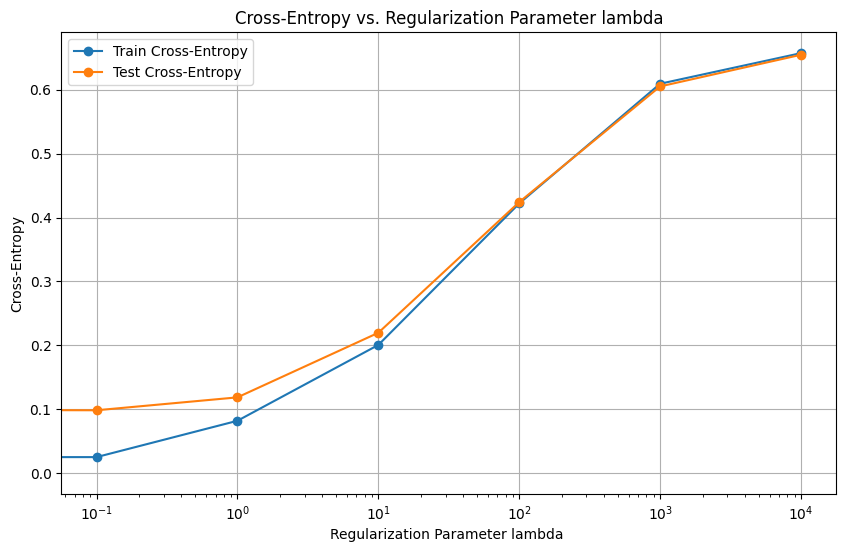

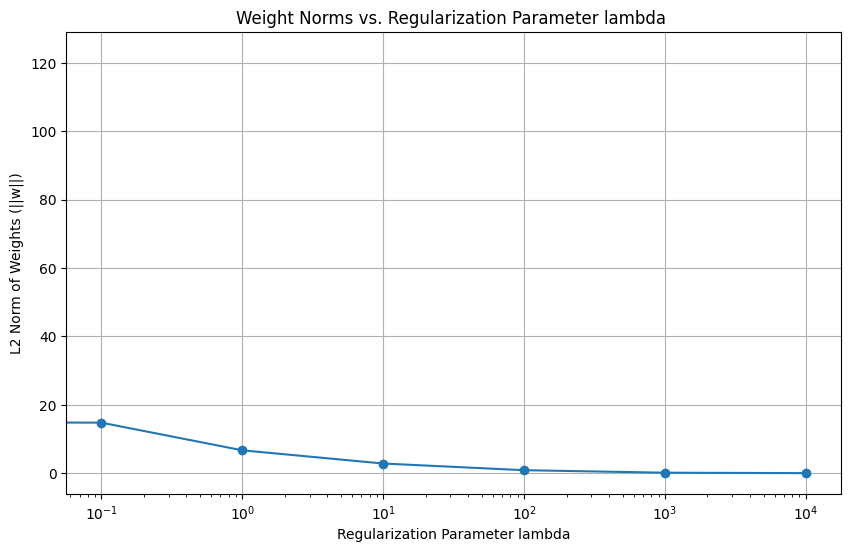

In [42]:
# Combine Gaussian features from all sigma
Phi_train_all = np.concatenate([gaussian_basis(X_train, s) for s in sigmas], axis=1)
Phi_test_all = np.concatenate([gaussian_basis(X_test, s) for s in sigmas], axis=1)

lambdas_g = [0, 0.1, 1, 10, 100, 1000, 10000]
cross_entropy_train_g, cross_entropy_test_g, weights_norms_g = [], [], []

for lam in lambdas_g:
    res = fit_eval_logreg(Phi_train_all, y_train, Phi_test_all, y_test, lambda_val=lam)
    cross_entropy_train_g.append(res["cross_entropy_train"])
    cross_entropy_test_g.append(res["cross_entropy_test"])
    weights_norms_g.append(np.linalg.norm(res["weights"]))

plt.figure(figsize=(10, 6))
plt.plot(lambdas_g, cross_entropy_train_g, 'o-', label="Train Cross-Entropy")
plt.plot(lambdas_g, cross_entropy_test_g, 'o-', label="Test Cross-Entropy")
plt.xscale("log")
plt.xlabel("Regularization Parameter lambda ")
plt.ylabel("Cross-Entropy")
plt.title("Cross-Entropy vs. Regularization Parameter lambda")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(lambdas_g, weights_norms_g, 'o-')
plt.xscale("log")
plt.ylabel("L2 Norm of Weights (||w||)")
plt.xlabel("Regularization Parameter lambda")
plt.title("Weight Norms vs. Regularization Parameter lambda ")
plt.grid(True)
plt.show()

#(h) Explain what you would need to do if you wanted to design a set of Gaussian basis functionsthat capture relationships between the inputs. Explain the impact of this choice the bias-variance trade-off.

To design a set of Gaussian basis functions that capture relationships between inputs, we would need to define the means and variances for each function. The means determine where each Gaussian is centered in the input space. we can place these centers at locations where we expect data to be clustered, perhaps using a clustering algorithm like k-means, or by distributing them on a regular grid. This choice helps the model focus on areas of the input space where relationships are most relevant. The variances control the width or spread of each Gaussian, dictating its influence. A small variance creates a narrow, localized function that can capture fine-grained, local features, while a large variance creates a broad function that can capture more global trends. By adjusting these parameters, we can control the model's flexibility and its ability to fit the data.  This design choice directly impacts the bias-variance trade-off. Using a small number of basis functions or functions with large variances results in a high-bias, low-variance model. Such a model is inflexible, leading to underfitting because it cannot capture intricate data variations, though it remains stable across different datasets.Using a large number of basis functions or functions with small variances leads to a low-bias, high-variance model. This flexible model can closely fit the training data, potentially leading to overfitting, where it becomes overly sensitive to noise and performs poorly on new data.

#(i) Suppose that instead of wanting to use a fixed set of evenly-spaced basis functions, you wouldlike to adapt the placement of these functions. Derive a learning algorithm that computes both the placement of the basis function, μi and the weight vector w from data (assuming that the width σ isfixed. You should still allow for L2 regularization of the weight vector.Note that your algorithm will need to be iterative.)

To design a learning algorithm that can adapt the placement of basis functions, you would need to use an iterative optimization approach. First, you define a loss function, which is a way to measure how well your model's predictions match the actual data. A common choice is the squared error between the model's output and the target values, with an added penalty on the size of the weights (L2 regularization) to keep the model from becoming too complex. Next, you calculate the gradients of this loss function with respect to both the weights and the basis function centers. The gradient for a weight tells you how much the error changes as you adjust that weight, while the gradient for a center tells you how the error changes as you move that basis function's location. Using these gradients, you iteratively update the parameters in small steps. For each weight and each basis function center, you adjust its value in the direction that reduces the error. The size of these adjustments is controlled by a learning rate. You repeat this process on your training data, and with each iteration, the model's performance improves as it learns the best weights and the optimal locations for its basis functions. This approach is more flexible than using a fixed set of evenly-spaced basis functions because it allows the model to find the most effective locations for the basis functions directly from the data.

#(j) Does your algorithm converge? If so, does it obtain a locally or globally optimal solution? Explain your answer.

The algorithm is designed to converge because in each step, it moves the parameters (weights and basis function centers) in the direction of steepest descent on the error surface. As long as the learning rates are appropriately chosen, each step reduces the error. The algorithm will continue to reduce the error until it reaches a point where the gradient is zero or close to zero, at which point it stops. This ensures it will converge to a minimum of the error function.

**Local vs. Global Optimum:**

The reason the solution is only a local optimum is due to the nature of the error function. When you're optimizing both the weights and the basis function centers, the error surface is highly non-convex. This means the surface is full of many "valleys" or minima. The algorithm starts at an initial set of parameters and simply follows the path of steepest descent. It will find the bottom of whichever valley it starts in, but it has no way of knowing if there's a deeper valley somewhere else on the error surface. The final solution is highly dependent on the initial random starting points of the weights and centers.  You might find a good solution, but there's no guarantee it's the very best possible solution (the global optimum).

#Q2: Linear Regression & Logistic Regression on Complex Dataset

In [35]:
from sklearn.datasets import load_wine
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load regression dataset
wine = load_wine()
X_reg, y_reg_target = wine.data, wine.target

X_reg = np.delete(X_reg, 2, axis=1)
y_reg = wine.data[:, 2]


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Models to compare
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
}

for name, model in models.items():
    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    pipe.fit(X_train_reg, y_train_reg)
    y_pred = pipe.predict(X_test_reg)
    print(f"{name} -> RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred)):.2f}, R²: {r2_score(y_test_reg, y_pred):.3f}")

Linear -> RMSE: 0.20, R²: 0.394
Ridge -> RMSE: 0.20, R²: 0.396
Lasso -> RMSE: 0.20, R²: 0.406
ElasticNet -> RMSE: 0.20, R²: 0.406


Test Accuracy: 0.9722222222222222
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



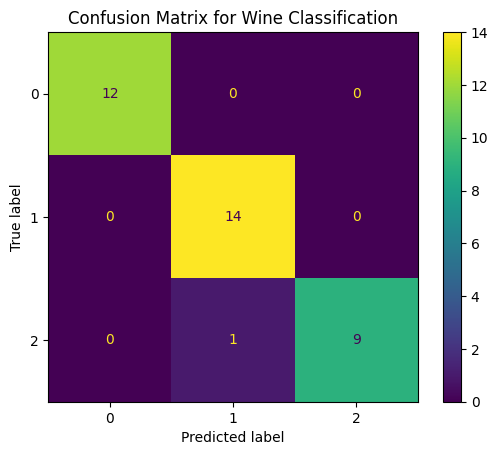

In [36]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the Wine dataset
wine = load_wine()
X_wine, y_wine = wine.data, wine.target

# Split the data into training and testing sets
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, stratify=y_wine, random_state=42
)

# Scale the features
scaler_wine = StandardScaler()
X_train_wine_scaled = scaler_wine.fit_transform(X_train_wine)
X_test_wine_scaled = scaler_wine.transform(X_test_wine)

# Train a Logistic Regression classifier
logreg_wine = LogisticRegression(max_iter=2000)
logreg_wine.fit(X_train_wine_scaled, y_train_wine)

# Make predictions and evaluate the model
y_pred_wine = logreg_wine.predict(X_test_wine_scaled)

print("Test Accuracy:", accuracy_score(y_test_wine, y_pred_wine))
print(classification_report(y_test_wine, y_pred_wine))

# confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg_wine, X_test_wine_scaled, y_test_wine)
plt.title("Confusion Matrix for Wine Classification")
plt.show()